In [1]:
import joblib
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, Subset
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

loaded_data = joblib.load("train_data.pkl")

targets, data, ids = loaded_data

# 打印某个人的具体信息

for i in tqdm(range(277)):
    if ids[i] == "44a41bba1ee7":
        print(f"Target: {targets[i]}")
        print(f"{data[i]}")
        print(type(targets[i]))
        print(type(data[i]))

100%|██████████| 277/277 [00:00<00:00, 18516.57it/s]

Target: [(6228, 12324), (22044, 28248), (59016, 65064), (78024, 82068), (95400, 99444), (109956, 114480), (126780, 132972), (144984, 151944), (191376, 199020), (211716, 217476), (243036, 251184)]
           anglez      enmo      step
0       26.234375  0.142456       0.0
1       25.828125  0.142456       1.0
2       25.687500  0.140015       2.0
3       26.640625  0.141968       3.0
4       26.140625  0.154053       4.0
...           ...       ...       ...
328135  -2.517578  0.027496  328135.0
328136 -10.000000  0.016602  328136.0
328137 -12.046875  0.015198  328137.0
328138 -12.585938  0.013901  328138.0
328139 -16.937500  0.013000  328139.0

[328140 rows x 3 columns]
<class 'list'>
<class 'pandas.core.frame.DataFrame'>


In [2]:
class CFG:
    window_overlap = 30
    window_size = 60
    train_ratio = 0.8
    batch_size = 32
    input_dim = 2
    embed_dim = 32
    num_classes = 3 
    num_layers = 6
    nhead = 4
    dim_feedforward = 64
    learning_rate = 1e-3
    epochs = 10
    train_record_steps = 80
    test_record_steps = 20
    dropout = 0.4
    num_person = 277
    scheduler_step_size = 30
    scheduler_gamma = 0.8

In [3]:
# 生成放入模型的数据，假设使用30分钟作为一个窗口，那么需要找的为形状（360，2）的矩阵

train_events = pd.read_csv("./train_events.csv")
num_person = len(train_events["series_id"].unique())
print("The number of total persons is:", num_person)

# 用来存储模型的输入与标签
X = []
y = []

for i in tqdm(range(min(num_person, CFG.num_person))):

    df = data[i]
    pair_list = targets[i]
    sleep_id = ids[i]

    # 先提取出开始睡觉和结束睡觉的时间
    onset_steps = []
    wakeup_steps = []
    for j in range(len(pair_list)):
        onset_steps.append(pair_list[j][0])
        wakeup_steps.append(pair_list[j][1])
    # print("length of onset list:", len(onset_steps))
    # print("length of wakeup list:", len(wakeup_steps))
    # print(onset_steps)
    # print(wakeup_steps)

    # 中间没有明确时间点的区间全部都不要
    empty_spaces = []
    events = train_events[train_events["series_id"] == sleep_id]
    last_events = 0
    mark = 0 
    for (idx, row) in events.iterrows():
        if np.isnan(row["step"]):
            mark = 1
        else:
            if row["step"] > last_events and mark == 0:
                last_events = row["step"]
            elif row["step"] > last_events and mark == 1:
                empty_spaces.append((int(last_events + 720), int(row["step"] - 720)))
                last_events = row["step"]
                mark = 0

    # print(empty_spaces)

    # 为训练数据设置label，如果区间中没有任何事件，标签为0，如果有开始睡觉事件，标签为1，如果有结束睡觉事件，标签为2
    labels = []
    for j in range(0, len(df), CFG.window_overlap):
        start = j
        if j + CFG.window_size >= len(df):
            break
        else:
            end = j + CFG.window_size

        flag = 0
        for k in empty_spaces:
            if (k[0] <= start <= k[1]) or (k[0] <= end <= k[1]):
                flag = 1
                break
            else:
                continue

        chunk = df.iloc[start:end][["anglez", "enmo"]]
        chunk = chunk.to_numpy()

        if flag == 1:
            label = 3
        elif any(start <= num <= end for num in wakeup_steps):
            label = 2
        elif any(start <= num <= end for num in onset_steps):
            label = 1
        else:
            label = 0
        labels.append(label)

        if label != 3:
            X.append(chunk)
            y.append(label)

    element_counts = Counter(labels)

    for element, count in element_counts.items():
        print(f'Element {element} occurs {count} times')

print(len(X), len(y))

The number of total persons is: 277


  0%|          | 1/200 [00:05<16:51,  5.08s/it]

Element 0 occurs 10313 times
Element 1 occurs 43 times
Element 2 occurs 42 times
Element 3 occurs 2596 times


  1%|          | 2/200 [00:14<24:44,  7.50s/it]

Element 0 occurs 19221 times
Element 1 occurs 19 times
Element 2 occurs 18 times
Element 3 occurs 4878 times


  2%|▏         | 3/200 [00:19<21:04,  6.42s/it]

Element 0 occurs 10152 times
Element 1 occurs 39 times
Element 2 occurs 40 times
Element 3 occurs 3009 times


  2%|▏         | 4/200 [00:27<23:06,  7.08s/it]

Element 0 occurs 16909 times
Element 3 occurs 4250 times
Element 1 occurs 44 times
Element 2 occurs 47 times


  2%|▎         | 5/200 [00:32<20:38,  6.35s/it]

Element 0 occurs 12687 times
Element 3 occurs 639 times
Element 1 occurs 16 times
Element 2 occurs 18 times


  3%|▎         | 6/200 [00:38<19:47,  6.12s/it]

Element 0 occurs 8673 times
Element 1 occurs 6 times
Element 2 occurs 7 times
Element 3 occurs 6060 times


  4%|▎         | 7/200 [00:48<23:36,  7.34s/it]

Element 0 occurs 16916 times
Element 1 occurs 33 times
Element 2 occurs 29 times
Element 3 occurs 8976 times


  4%|▍         | 8/200 [00:53<21:44,  6.79s/it]

Element 0 occurs 14561 times
Element 1 occurs 56 times
Element 2 occurs 57 times


  4%|▍         | 9/200 [00:57<18:56,  5.95s/it]

Element 0 occurs 8495 times
Element 1 occurs 32 times
Element 2 occurs 33 times


  5%|▌         | 10/200 [01:03<18:33,  5.86s/it]

Element 0 occurs 7972 times
Element 1 occurs 12 times
Element 2 occurs 13 times
Element 3 occurs 4343 times


  6%|▌         | 11/200 [01:11<20:58,  6.66s/it]

Element 0 occurs 19506 times
Element 1 occurs 70 times
Element 2 occurs 67 times
Element 3 occurs 527 times


  6%|▌         | 12/200 [01:17<19:25,  6.20s/it]

Element 0 occurs 12731 times
Element 1 occurs 45 times
Element 2 occurs 44 times


  6%|▋         | 13/200 [01:22<18:33,  5.95s/it]

Element 0 occurs 11025 times
Element 1 occurs 42 times
Element 2 occurs 47 times
Element 3 occurs 2378 times


  7%|▋         | 14/200 [01:27<18:00,  5.81s/it]

Element 0 occurs 10072 times
Element 1 occurs 46 times
Element 2 occurs 46 times
Element 3 occurs 3538 times


  8%|▊         | 15/200 [01:35<19:46,  6.41s/it]

Element 0 occurs 16924 times
Element 1 occurs 64 times
Element 2 occurs 67 times
Element 3 occurs 2041 times


  8%|▊         | 16/200 [01:40<18:16,  5.96s/it]

Element 0 occurs 12003 times
Element 1 occurs 47 times
Element 2 occurs 44 times


  8%|▊         | 17/200 [01:49<20:25,  6.70s/it]

Element 0 occurs 11254 times
Element 1 occurs 48 times
Element 2 occurs 46 times
Element 3 occurs 5846 times


  9%|▉         | 18/200 [01:54<19:09,  6.31s/it]

Element 0 occurs 8890 times


 10%|▉         | 19/200 [02:01<19:39,  6.52s/it]

Element 0 occurs 12535 times
Element 1 occurs 7 times
Element 2 occurs 7 times
Element 3 occurs 883 times


 10%|█         | 20/200 [02:09<21:04,  7.02s/it]

Element 0 occurs 13593 times
Element 1 occurs 51 times
Element 2 occurs 52 times


 10%|█         | 21/200 [02:17<21:16,  7.13s/it]

Element 0 occurs 12980 times
Element 1 occurs 48 times
Element 2 occurs 50 times


 11%|█         | 22/200 [02:28<25:20,  8.54s/it]

Element 0 occurs 22994 times
Element 1 occurs 59 times
Element 2 occurs 62 times
Element 3 occurs 1699 times


 12%|█▏        | 23/200 [02:38<26:09,  8.87s/it]

Element 0 occurs 19920 times
Element 1 occurs 70 times
Element 2 occurs 72 times


 12%|█▏        | 24/200 [02:46<25:37,  8.74s/it]

Element 0 occurs 14118 times
Element 1 occurs 8 times
Element 2 occurs 8 times


 12%|█▎        | 25/200 [02:55<25:34,  8.77s/it]

Element 0 occurs 11898 times
Element 1 occurs 40 times
Element 2 occurs 42 times
Element 3 occurs 7416 times


 13%|█▎        | 26/200 [03:01<22:40,  7.82s/it]

Element 0 occurs 13328 times
Element 3 occurs 806 times
Element 1 occurs 10 times
Element 2 occurs 8 times


 14%|█▎        | 27/200 [03:09<22:24,  7.77s/it]

Element 0 occurs 11502 times
Element 1 occurs 35 times
Element 2 occurs 35 times
Element 3 occurs 6774 times


 14%|█▍        | 28/200 [03:18<23:31,  8.21s/it]

Element 0 occurs 17744 times
Element 1 occurs 66 times
Element 2 occurs 70 times
Element 3 occurs 526 times


 14%|█▍        | 29/200 [03:24<21:27,  7.53s/it]

Element 0 occurs 5717 times
Element 1 occurs 31 times
Element 2 occurs 30 times
Element 3 occurs 7036 times


 15%|█▌        | 30/200 [03:30<20:32,  7.25s/it]

Element 0 occurs 15844 times
Element 1 occurs 56 times
Element 2 occurs 58 times


 16%|█▌        | 31/200 [03:36<19:15,  6.84s/it]

Element 0 occurs 12374 times
Element 1 occurs 41 times
Element 2 occurs 44 times
Element 3 occurs 1843 times


 16%|█▌        | 32/200 [03:42<17:53,  6.39s/it]

Element 0 occurs 11871 times
Element 1 occurs 50 times
Element 2 occurs 44 times
Element 3 occurs 915 times


 16%|█▋        | 33/200 [03:51<20:04,  7.21s/it]

Element 0 occurs 19194 times
Element 1 occurs 69 times
Element 2 occurs 66 times
Element 3 occurs 877 times


 17%|█▋        | 34/200 [03:58<19:58,  7.22s/it]

Element 0 occurs 16388 times
Element 1 occurs 63 times
Element 2 occurs 65 times


 18%|█▊        | 35/200 [04:07<21:29,  7.81s/it]

Element 0 occurs 18354 times
Element 1 occurs 67 times
Element 2 occurs 63 times


 18%|█▊        | 36/200 [04:14<20:11,  7.39s/it]

Element 0 occurs 11902 times
Element 1 occurs 46 times
Element 2 occurs 44 times
Element 3 occurs 948 times


 18%|█▊        | 37/200 [04:15<15:27,  5.69s/it]

Element 0 occurs 2905 times
Element 1 occurs 14 times
Element 2 occurs 12 times
Element 3 occurs 913 times


 19%|█▉        | 38/200 [04:26<19:04,  7.06s/it]

Element 0 occurs 5490 times
Element 3 occurs 14592 times
Element 1 occurs 22 times
Element 2 occurs 24 times


 20%|█▉        | 39/200 [04:33<19:29,  7.26s/it]

Element 0 occurs 15435 times
Element 1 occurs 14 times
Element 2 occurs 13 times
Element 3 occurs 2368 times


 20%|██        | 40/200 [04:42<20:44,  7.78s/it]

Element 0 occurs 8271 times
Element 3 occurs 11103 times
Element 1 occurs 33 times
Element 2 occurs 31 times


 20%|██        | 41/200 [04:48<19:11,  7.24s/it]

Element 0 occurs 11020 times
Element 1 occurs 40 times
Element 2 occurs 39 times
Element 3 occurs 1961 times


 21%|██        | 42/200 [04:59<21:40,  8.23s/it]

Element 0 occurs 20529 times
Element 1 occurs 79 times
Element 2 occurs 76 times
Element 3 occurs 1802 times


 22%|██▏       | 43/200 [05:09<23:13,  8.88s/it]

Element 0 occurs 21261 times
Element 1 occurs 18 times
Element 2 occurs 19 times


 22%|██▏       | 44/200 [05:16<21:10,  8.14s/it]

Element 0 occurs 11706 times
Element 1 occurs 45 times
Element 2 occurs 46 times
Element 3 occurs 867 times


 22%|██▎       | 45/200 [05:25<22:06,  8.56s/it]

Element 0 occurs 9564 times
Element 1 occurs 46 times
Element 2 occurs 51 times
Element 3 occurs 10731 times


 23%|██▎       | 46/200 [05:33<21:37,  8.43s/it]

Element 0 occurs 11927 times
Element 1 occurs 52 times
Element 2 occurs 50 times
Element 3 occurs 6509 times


 24%|██▎       | 47/200 [05:41<20:56,  8.21s/it]

Element 0 occurs 15343 times
Element 1 occurs 62 times
Element 2 occurs 67 times


 24%|██▍       | 48/200 [05:47<19:00,  7.50s/it]

Element 0 occurs 7823 times
Element 1 occurs 33 times
Element 2 occurs 30 times
Element 3 occurs 5294 times


 24%|██▍       | 49/200 [05:53<18:14,  7.25s/it]

Element 0 occurs 11890 times
Element 1 occurs 49 times
Element 2 occurs 49 times
Element 3 occurs 3178 times


 25%|██▌       | 50/200 [06:03<19:40,  7.87s/it]

Element 0 occurs 18036 times
Element 1 occurs 69 times
Element 2 occurs 67 times
Element 3 occurs 1860 times


 26%|██▌       | 51/200 [06:11<20:03,  8.08s/it]

Element 0 occurs 17118 times
Element 1 occurs 25 times
Element 2 occurs 24 times
Element 3 occurs 2439 times


 26%|██▌       | 52/200 [06:15<16:36,  6.73s/it]

Element 0 occurs 6123 times
Element 1 occurs 26 times
Element 2 occurs 27 times
Element 3 occurs 1874 times


 26%|██▋       | 53/200 [06:20<15:22,  6.27s/it]

Element 0 occurs 10856 times
Element 1 occurs 40 times
Element 2 occurs 37 times
Element 3 occurs 879 times


 27%|██▋       | 54/200 [06:26<15:03,  6.19s/it]

Element 0 occurs 12442 times
Element 1 occurs 47 times
Element 2 occurs 43 times
Element 3 occurs 864 times


 28%|██▊       | 55/200 [06:32<14:52,  6.15s/it]

Element 0 occurs 13894 times


 28%|██▊       | 56/200 [06:42<17:31,  7.30s/it]

Element 0 occurs 18779 times
Element 1 occurs 23 times
Element 2 occurs 24 times


 28%|██▊       | 57/200 [06:52<19:05,  8.01s/it]

Element 0 occurs 19736 times
Element 3 occurs 2511 times
Element 1 occurs 72 times
Element 2 occurs 71 times


 29%|██▉       | 58/200 [06:58<17:21,  7.34s/it]

Element 0 occurs 11531 times
Element 1 occurs 46 times
Element 2 occurs 49 times
Element 3 occurs 2334 times


 30%|██▉       | 59/200 [07:05<17:14,  7.33s/it]

Element 0 occurs 17711 times
Element 1 occurs 68 times
Element 2 occurs 69 times


 30%|███       | 60/200 [07:05<12:20,  5.29s/it]

Element 0 occurs 1225 times
Element 1 occurs 5 times
Element 2 occurs 4 times


 30%|███       | 61/200 [07:11<12:38,  5.46s/it]

Element 0 occurs 13460 times
Element 1 occurs 29 times
Element 2 occurs 29 times
Element 3 occurs 868 times


 31%|███       | 62/200 [07:16<12:02,  5.24s/it]

Element 0 occurs 9786 times
Element 1 occurs 38 times
Element 2 occurs 39 times
Element 3 occurs 1763 times


 32%|███▏      | 63/200 [07:21<12:00,  5.26s/it]

Element 0 occurs 12563 times
Element 1 occurs 53 times
Element 2 occurs 48 times


 32%|███▏      | 64/200 [07:27<12:09,  5.36s/it]

Element 0 occurs 12053 times
Element 1 occurs 41 times
Element 2 occurs 38 times
Element 3 occurs 1402 times


 32%|███▎      | 65/200 [07:33<12:13,  5.43s/it]

Element 0 occurs 13204 times


 33%|███▎      | 66/200 [07:34<09:27,  4.24s/it]

Element 0 occurs 840 times
Element 1 occurs 5 times
Element 2 occurs 4 times
Element 3 occurs 2599 times


 34%|███▎      | 67/200 [07:42<12:01,  5.43s/it]

Element 0 occurs 16744 times
Element 1 occurs 65 times
Element 2 occurs 66 times
Element 3 occurs 2941 times


 34%|███▍      | 68/200 [07:49<12:56,  5.89s/it]

Element 0 occurs 11540 times
Element 1 occurs 43 times
Element 2 occurs 46 times
Element 3 occurs 2025 times


 34%|███▍      | 69/200 [07:57<14:22,  6.59s/it]

Element 0 occurs 6134 times
Element 1 occurs 9 times
Element 2 occurs 9 times
Element 3 occurs 8360 times


 35%|███▌      | 70/200 [08:03<13:41,  6.32s/it]

Element 0 occurs 6232 times
Element 1 occurs 29 times
Element 2 occurs 29 times
Element 3 occurs 6806 times


 36%|███▌      | 71/200 [08:09<13:10,  6.13s/it]

Element 0 occurs 11025 times
Element 1 occurs 42 times
Element 2 occurs 44 times
Element 3 occurs 2363 times


 36%|███▌      | 72/200 [08:14<12:47,  6.00s/it]

Element 0 occurs 9039 times
Element 1 occurs 24 times
Element 2 occurs 26 times
Element 3 occurs 3845 times


 36%|███▋      | 73/200 [08:20<12:18,  5.81s/it]

Element 0 occurs 13293 times
Element 1 occurs 7 times
Element 2 occurs 6 times


 37%|███▋      | 74/200 [08:25<12:00,  5.72s/it]

Element 0 occurs 11464 times
Element 1 occurs 45 times
Element 2 occurs 46 times
Element 3 occurs 1517 times


 38%|███▊      | 75/200 [08:34<13:36,  6.53s/it]

Element 0 occurs 14863 times
Element 1 occurs 64 times
Element 2 occurs 65 times
Element 3 occurs 5268 times


 38%|███▊      | 76/200 [08:39<12:56,  6.27s/it]

Element 0 occurs 12486 times
Element 1 occurs 54 times
Element 2 occurs 48 times
Element 3 occurs 838 times


 38%|███▊      | 77/200 [08:44<11:46,  5.75s/it]

Element 0 occurs 7879 times
Element 1 occurs 24 times
Element 2 occurs 24 times
Element 3 occurs 3009 times


 39%|███▉      | 78/200 [08:50<11:45,  5.78s/it]

Element 0 occurs 6965 times
Element 3 occurs 7231 times
Element 1 occurs 31 times
Element 2 occurs 27 times


 40%|███▉      | 79/200 [08:55<11:25,  5.67s/it]

Element 0 occurs 11340 times
Element 3 occurs 1556 times
Element 1 occurs 44 times
Element 2 occurs 48 times


 40%|████      | 80/200 [08:59<10:17,  5.14s/it]

Element 0 occurs 9502 times
Element 1 occurs 38 times
Element 2 occurs 40 times


 40%|████      | 81/200 [09:07<11:36,  5.85s/it]

Element 0 occurs 16111 times
Element 3 occurs 1516 times
Element 1 occurs 69 times
Element 2 occurs 62 times


 41%|████      | 82/200 [09:12<11:31,  5.86s/it]

Element 0 occurs 12884 times
Element 1 occurs 49 times
Element 2 occurs 50 times
Element 3 occurs 941 times


 42%|████▏     | 83/200 [09:18<11:09,  5.72s/it]

Element 0 occurs 11275 times
Element 1 occurs 39 times
Element 2 occurs 43 times
Element 3 occurs 1565 times


 42%|████▏     | 84/200 [09:23<10:50,  5.61s/it]

Element 0 occurs 11773 times
Element 3 occurs 805 times
Element 1 occurs 43 times
Element 2 occurs 43 times


 42%|████▎     | 85/200 [09:33<13:13,  6.90s/it]

Element 0 occurs 10443 times
Element 3 occurs 13700 times
Element 1 occurs 32 times
Element 2 occurs 33 times


 43%|████▎     | 86/200 [09:39<12:21,  6.51s/it]

Element 0 occurs 4126 times
Element 1 occurs 15 times
Element 2 occurs 16 times
Element 3 occurs 9491 times


 44%|████▎     | 87/200 [09:46<12:36,  6.69s/it]

Element 0 occurs 16312 times
Element 1 occurs 66 times
Element 2 occurs 67 times
Element 3 occurs 815 times


 44%|████▍     | 88/200 [09:52<12:00,  6.43s/it]

Element 0 occurs 9141 times
Element 1 occurs 36 times
Element 2 occurs 34 times
Element 3 occurs 4797 times


 44%|████▍     | 89/200 [09:57<11:25,  6.18s/it]

Element 0 occurs 8727 times
Element 1 occurs 35 times
Element 2 occurs 36 times
Element 3 occurs 3830 times


 45%|████▌     | 90/200 [10:03<10:59,  5.99s/it]

Element 0 occurs 11445 times
Element 1 occurs 44 times
Element 2 occurs 50 times
Element 3 occurs 1815 times


 46%|████▌     | 91/200 [10:09<10:44,  5.91s/it]

Element 0 occurs 13649 times
Element 1 occurs 52 times
Element 2 occurs 55 times


 46%|████▌     | 92/200 [10:17<12:11,  6.77s/it]

Element 0 occurs 13211 times
Element 1 occurs 49 times
Element 2 occurs 48 times
Element 3 occurs 7366 times


 46%|████▋     | 93/200 [10:26<13:00,  7.29s/it]

Element 0 occurs 17335 times
Element 1 occurs 72 times
Element 2 occurs 67 times
Element 3 occurs 2576 times


 47%|████▋     | 94/200 [10:32<12:03,  6.82s/it]

Element 0 occurs 13673 times
Element 1 occurs 3 times
Element 2 occurs 2 times


 48%|████▊     | 95/200 [10:38<11:32,  6.60s/it]

Element 0 occurs 13491 times
Element 1 occurs 50 times
Element 2 occurs 53 times


 48%|████▊     | 96/200 [10:43<10:51,  6.26s/it]

Element 0 occurs 10464 times
Element 1 occurs 39 times
Element 2 occurs 34 times
Element 3 occurs 2397 times


 48%|████▊     | 97/200 [10:49<10:23,  6.05s/it]

Element 0 occurs 13151 times
Element 1 occurs 43 times
Element 2 occurs 46 times


 49%|████▉     | 98/200 [10:51<08:10,  4.81s/it]

Element 0 occurs 1997 times
Element 1 occurs 7 times
Element 2 occurs 6 times
Element 3 occurs 2542 times


 50%|████▉     | 99/200 [10:56<08:10,  4.85s/it]

Element 0 occurs 8963 times
Element 1 occurs 37 times
Element 2 occurs 37 times
Element 3 occurs 2925 times


 50%|█████     | 100/200 [11:01<08:19,  4.99s/it]

Element 0 occurs 12006 times
Element 1 occurs 49 times
Element 2 occurs 46 times
Element 3 occurs 893 times


 50%|█████     | 101/200 [11:06<08:30,  5.16s/it]

Element 0 occurs 13378 times
Element 1 occurs 48 times
Element 2 occurs 48 times


 51%|█████     | 102/200 [11:15<09:56,  6.09s/it]

Element 0 occurs 17603 times
Element 1 occurs 73 times
Element 2 occurs 72 times
Element 3 occurs 1768 times


 52%|█████▏    | 103/200 [11:23<10:54,  6.75s/it]

Element 0 occurs 18809 times
Element 1 occurs 69 times
Element 2 occurs 72 times
Element 3 occurs 884 times


 52%|█████▏    | 104/200 [11:29<10:25,  6.52s/it]

Element 0 occurs 10987 times
Element 3 occurs 3505 times
Element 1 occurs 26 times
Element 2 occurs 24 times


 52%|█████▎    | 105/200 [11:31<07:59,  5.05s/it]

Element 0 occurs 2865 times
Element 1 occurs 6 times
Element 2 occurs 8 times
Element 3 occurs 917 times


 53%|█████▎    | 106/200 [11:37<08:21,  5.34s/it]

Element 0 occurs 12591 times
Element 1 occurs 25 times
Element 2 occurs 27 times
Element 3 occurs 1683 times


 54%|█████▎    | 107/200 [11:45<09:29,  6.13s/it]

Element 0 occurs 17815 times
Element 1 occurs 70 times
Element 2 occurs 68 times
Element 3 occurs 951 times


 54%|█████▍    | 108/200 [11:50<09:04,  5.92s/it]

Element 0 occurs 12809 times
Element 1 occurs 51 times
Element 2 occurs 50 times


 55%|█████▍    | 109/200 [11:55<08:40,  5.72s/it]

Element 0 occurs 12446 times
Element 1 occurs 50 times
Element 2 occurs 48 times


 55%|█████▌    | 110/200 [12:05<10:15,  6.84s/it]

Element 0 occurs 20527 times
Element 1 occurs 61 times
Element 2 occurs 54 times
Element 3 occurs 1994 times


 56%|█████▌    | 111/200 [12:13<10:46,  7.26s/it]

Element 0 occurs 8916 times
Element 1 occurs 36 times
Element 2 occurs 37 times
Element 3 occurs 11115 times


 56%|█████▌    | 112/200 [12:19<09:58,  6.80s/it]

Element 0 occurs 7036 times
Element 1 occurs 35 times
Element 2 occurs 32 times
Element 3 occurs 6647 times


 56%|█████▋    | 113/200 [12:29<11:25,  7.87s/it]

Element 0 occurs 15933 times
Element 1 occurs 69 times
Element 2 occurs 65 times
Element 3 occurs 9239 times


 57%|█████▋    | 114/200 [12:39<12:06,  8.44s/it]

Element 0 occurs 18639 times
Element 1 occurs 75 times
Element 2 occurs 71 times
Element 3 occurs 4139 times


 57%|█████▊    | 115/200 [12:45<10:50,  7.65s/it]

Element 0 occurs 14105 times
Element 1 occurs 51 times
Element 2 occurs 50 times


 58%|█████▊    | 116/200 [12:50<09:54,  7.07s/it]

Element 0 occurs 6534 times
Element 1 occurs 32 times
Element 2 occurs 32 times
Element 3 occurs 7116 times


 58%|█████▊    | 117/200 [12:56<09:11,  6.64s/it]

Element 0 occurs 10957 times
Element 1 occurs 13 times
Element 2 occurs 11 times
Element 3 occurs 2049 times


 59%|█████▉    | 118/200 [13:01<08:36,  6.29s/it]

Element 0 occurs 8966 times
Element 1 occurs 35 times
Element 2 occurs 32 times
Element 3 occurs 4045 times


 60%|█████▉    | 119/200 [13:07<08:07,  6.02s/it]

Element 0 occurs 12932 times
Element 1 occurs 49 times
Element 2 occurs 49 times


 60%|██████    | 120/200 [13:15<08:41,  6.52s/it]

Element 0 occurs 18414 times
Element 1 occurs 65 times
Element 2 occurs 65 times


 60%|██████    | 121/200 [13:20<08:14,  6.26s/it]

Element 0 occurs 9920 times
Element 1 occurs 10 times
Element 2 occurs 10 times
Element 3 occurs 3828 times


 61%|██████    | 122/200 [13:26<07:53,  6.07s/it]

Element 0 occurs 11752 times
Element 3 occurs 1833 times
Element 1 occurs 5 times
Element 2 occurs 4 times


 62%|██████▏   | 123/200 [13:31<07:35,  5.92s/it]

Element 0 occurs 12385 times
Element 1 occurs 50 times
Element 2 occurs 49 times
Element 3 occurs 870 times


 62%|██████▏   | 124/200 [13:36<07:11,  5.67s/it]

Element 0 occurs 12265 times
Element 1 occurs 47 times
Element 2 occurs 46 times


 62%|██████▎   | 125/200 [13:42<07:06,  5.69s/it]

Element 0 occurs 13659 times
Element 1 occurs 52 times
Element 2 occurs 51 times


 63%|██████▎   | 126/200 [13:50<07:43,  6.26s/it]

Element 0 occurs 6661 times
Element 1 occurs 30 times
Element 2 occurs 31 times
Element 3 occurs 11732 times


 64%|██████▎   | 127/200 [13:56<07:26,  6.12s/it]

Element 0 occurs 13496 times
Element 1 occurs 51 times
Element 2 occurs 53 times


 64%|██████▍   | 128/200 [14:18<13:20, 11.11s/it]

Element 0 occurs 47741 times
Element 1 occurs 27 times
Element 2 occurs 26 times


 64%|██████▍   | 129/200 [14:24<11:17,  9.54s/it]

Element 0 occurs 7553 times
Element 1 occurs 37 times
Element 2 occurs 36 times
Element 3 occurs 5944 times


 65%|██████▌   | 130/200 [14:31<10:14,  8.78s/it]

Element 0 occurs 11974 times
Element 1 occurs 47 times
Element 2 occurs 48 times
Element 3 occurs 937 times


 66%|██████▌   | 131/200 [14:38<09:17,  8.08s/it]

Element 0 occurs 10392 times
Element 1 occurs 41 times
Element 2 occurs 48 times
Element 3 occurs 2363 times


 66%|██████▌   | 132/200 [14:44<08:35,  7.58s/it]

Element 0 occurs 13802 times
Element 1 occurs 52 times
Element 2 occurs 52 times


 66%|██████▋   | 133/200 [14:49<07:37,  6.83s/it]

Element 0 occurs 11282 times
Element 1 occurs 47 times
Element 2 occurs 44 times
Element 3 occurs 1447 times


 67%|██████▋   | 134/200 [14:52<06:08,  5.59s/it]

Element 0 occurs 4374 times
Element 1 occurs 18 times
Element 2 occurs 18 times
Element 3 occurs 2380 times


 68%|██████▊   | 135/200 [14:57<05:57,  5.49s/it]

Element 0 occurs 11367 times
Element 1 occurs 47 times
Element 2 occurs 48 times
Element 3 occurs 1682 times


 68%|██████▊   | 136/200 [15:06<06:57,  6.52s/it]

Element 0 occurs 14348 times
Element 1 occurs 7 times
Element 2 occurs 6 times
Element 3 occurs 8125 times


 68%|██████▊   | 137/200 [15:11<06:19,  6.02s/it]

Element 0 occurs 9985 times
Element 1 occurs 28 times
Element 2 occurs 29 times
Element 3 occurs 2316 times


 69%|██████▉   | 138/200 [15:16<05:51,  5.67s/it]

Element 0 occurs 11323 times
Element 1 occurs 44 times
Element 2 occurs 47 times
Element 3 occurs 884 times


 70%|██████▉   | 139/200 [15:25<06:43,  6.62s/it]

Element 0 occurs 22837 times
Element 1 occurs 17 times
Element 2 occurs 16 times


 70%|███████   | 140/200 [15:30<06:20,  6.34s/it]

Element 0 occurs 14194 times
Element 1 occurs 58 times
Element 2 occurs 56 times


 70%|███████   | 141/200 [15:36<05:57,  6.05s/it]

Element 0 occurs 13984 times


 71%|███████   | 142/200 [15:44<06:27,  6.68s/it]

Element 0 occurs 17676 times
Element 1 occurs 61 times
Element 2 occurs 61 times
Element 3 occurs 2762 times


 72%|███████▏  | 143/200 [15:50<06:14,  6.57s/it]

Element 0 occurs 13448 times
Element 1 occurs 48 times
Element 2 occurs 50 times


 72%|███████▏  | 144/200 [16:00<07:04,  7.57s/it]

Element 0 occurs 19334 times
Element 1 occurs 58 times
Element 2 occurs 57 times
Element 3 occurs 901 times


 72%|███████▎  | 145/200 [16:10<07:35,  8.28s/it]

Element 0 occurs 19266 times
Element 1 occurs 21 times
Element 2 occurs 19 times
Element 3 occurs 1476 times


 73%|███████▎  | 146/200 [16:16<06:52,  7.64s/it]

Element 0 occurs 13952 times
Element 1 occurs 27 times
Element 2 occurs 29 times


 74%|███████▎  | 147/200 [16:22<06:15,  7.09s/it]

Element 0 occurs 13410 times
Element 1 occurs 53 times
Element 2 occurs 53 times


 74%|███████▍  | 148/200 [16:31<06:36,  7.63s/it]

Element 0 occurs 17814 times
Element 3 occurs 2286 times
Element 1 occurs 27 times
Element 2 occurs 25 times


 74%|███████▍  | 149/200 [16:36<05:55,  6.98s/it]

Element 0 occurs 12815 times
Element 1 occurs 50 times
Element 2 occurs 51 times


 75%|███████▌  | 150/200 [16:41<05:20,  6.41s/it]

Element 0 occurs 6802 times
Element 3 occurs 6026 times
Element 1 occurs 28 times
Element 2 occurs 24 times


 76%|███████▌  | 151/200 [16:51<05:58,  7.32s/it]

Element 0 occurs 16081 times
Element 1 occurs 42 times
Element 2 occurs 44 times
Element 3 occurs 6151 times


 76%|███████▌  | 152/200 [16:57<05:31,  6.91s/it]

Element 0 occurs 13760 times
Element 1 occurs 50 times
Element 2 occurs 54 times


 76%|███████▋  | 153/200 [17:02<05:03,  6.47s/it]

Element 0 occurs 11280 times
Element 1 occurs 10 times
Element 2 occurs 8 times
Element 3 occurs 1762 times


 77%|███████▋  | 154/200 [17:07<04:39,  6.07s/it]

Element 0 occurs 11767 times
Element 1 occurs 42 times
Element 2 occurs 46 times
Element 3 occurs 887 times


 78%|███████▊  | 155/200 [17:14<04:36,  6.14s/it]

Element 0 occurs 13708 times
Element 1 occurs 52 times
Element 2 occurs 56 times


 78%|███████▊  | 156/200 [17:20<04:34,  6.25s/it]

Element 0 occurs 8948 times
Element 1 occurs 39 times
Element 2 occurs 39 times
Element 3 occurs 5216 times


 78%|███████▊  | 157/200 [17:27<04:33,  6.36s/it]

Element 0 occurs 13445 times
Element 1 occurs 53 times
Element 2 occurs 48 times


 79%|███████▉  | 158/200 [17:30<03:51,  5.51s/it]

Element 0 occurs 5220 times
Element 1 occurs 22 times
Element 2 occurs 20 times
Element 3 occurs 1432 times


 80%|███████▉  | 159/200 [17:39<04:24,  6.45s/it]

Element 0 occurs 17830 times
Element 1 occurs 60 times
Element 2 occurs 60 times
Element 3 occurs 2628 times


 80%|████████  | 160/200 [17:42<03:32,  5.32s/it]

Element 0 occurs 6485 times
Element 1 occurs 20 times
Element 2 occurs 21 times


 80%|████████  | 161/200 [17:47<03:29,  5.37s/it]

Element 0 occurs 9077 times
Element 1 occurs 38 times
Element 2 occurs 41 times
Element 3 occurs 3754 times


 81%|████████  | 162/200 [17:52<03:21,  5.29s/it]

Element 0 occurs 10599 times
Element 1 occurs 41 times
Element 2 occurs 39 times
Element 3 occurs 1889 times


 82%|████████▏ | 163/200 [17:58<03:21,  5.43s/it]

Element 0 occurs 13700 times
Element 1 occurs 46 times
Element 2 occurs 46 times


 82%|████████▏ | 164/200 [18:03<03:14,  5.40s/it]

Element 0 occurs 12895 times
Element 1 occurs 51 times
Element 2 occurs 48 times


 82%|████████▎ | 165/200 [18:09<03:09,  5.41s/it]

Element 0 occurs 10711 times
Element 1 occurs 39 times
Element 2 occurs 41 times
Element 3 occurs 2071 times


 83%|████████▎ | 166/200 [18:14<03:02,  5.36s/it]

Element 0 occurs 5494 times
Element 3 occurs 7708 times
Element 1 occurs 19 times
Element 2 occurs 19 times


 84%|████████▎ | 167/200 [18:19<02:56,  5.35s/it]

Element 0 occurs 8455 times
Element 1 occurs 26 times
Element 2 occurs 28 times
Element 3 occurs 5025 times


 84%|████████▍ | 168/200 [18:25<02:54,  5.47s/it]

Element 0 occurs 13326 times
Element 1 occurs 2 times
Element 2 occurs 2 times


 84%|████████▍ | 169/200 [18:32<03:02,  5.90s/it]

Element 0 occurs 13882 times


 85%|████████▌ | 170/200 [18:38<02:59,  5.97s/it]

Element 0 occurs 12035 times
Element 1 occurs 45 times
Element 2 occurs 48 times
Element 3 occurs 1670 times


 86%|████████▌ | 171/200 [18:46<03:14,  6.70s/it]

Element 0 occurs 20087 times
Element 1 occurs 29 times
Element 2 occurs 30 times


 86%|████████▌ | 172/200 [18:52<03:00,  6.46s/it]

Element 0 occurs 9891 times
Element 1 occurs 43 times
Element 2 occurs 43 times
Element 3 occurs 3923 times


 86%|████████▋ | 173/200 [18:58<02:46,  6.18s/it]

Element 0 occurs 12761 times
Element 1 occurs 48 times
Element 2 occurs 48 times
Element 3 occurs 905 times


 87%|████████▋ | 174/200 [19:01<02:15,  5.23s/it]

Element 0 occurs 6412 times
Element 1 occurs 6 times
Element 2 occurs 6 times


 88%|████████▊ | 175/200 [19:10<02:40,  6.44s/it]

Element 0 occurs 20999 times
Element 1 occurs 77 times
Element 2 occurs 78 times


 88%|████████▊ | 176/200 [19:13<02:07,  5.30s/it]

Element 0 occurs 5128 times
Element 1 occurs 22 times
Element 2 occurs 20 times


 88%|████████▊ | 177/200 [19:18<02:03,  5.37s/it]

Element 0 occurs 8534 times
Element 1 occurs 37 times
Element 2 occurs 35 times
Element 3 occurs 4706 times


 89%|████████▉ | 178/200 [19:25<02:04,  5.67s/it]

Element 0 occurs 10055 times
Element 1 occurs 42 times
Element 2 occurs 43 times
Element 3 occurs 5980 times


 90%|████████▉ | 179/200 [19:30<01:54,  5.46s/it]

Element 0 occurs 11334 times
Element 1 occurs 2 times
Element 2 occurs 2 times


 90%|█████████ | 180/200 [19:35<01:48,  5.43s/it]

Element 0 occurs 13623 times
Element 1 occurs 52 times
Element 2 occurs 51 times


 90%|█████████ | 181/200 [19:42<01:50,  5.79s/it]

Element 0 occurs 16673 times
Element 1 occurs 59 times
Element 2 occurs 54 times


 91%|█████████ | 182/200 [19:47<01:43,  5.76s/it]

Element 0 occurs 13290 times
Element 1 occurs 50 times
Element 2 occurs 56 times


 92%|█████████▏| 183/200 [19:53<01:36,  5.68s/it]

Element 0 occurs 12885 times
Element 1 occurs 46 times
Element 2 occurs 51 times
Element 3 occurs 834 times


 92%|█████████▏| 184/200 [20:00<01:36,  6.06s/it]

Element 0 occurs 13176 times
Element 1 occurs 27 times
Element 2 occurs 30 times
Element 3 occurs 1789 times


 92%|█████████▎| 185/200 [20:12<01:56,  7.79s/it]

Element 0 occurs 22990 times
Element 1 occurs 51 times
Element 2 occurs 57 times
Element 3 occurs 948 times


 93%|█████████▎| 186/200 [20:17<01:39,  7.12s/it]

Element 0 occurs 7334 times
Element 1 occurs 33 times
Element 2 occurs 40 times
Element 3 occurs 5635 times


 94%|█████████▎| 187/200 [20:25<01:34,  7.29s/it]

Element 0 occurs 17265 times
Element 3 occurs 1675 times
Element 1 occurs 6 times
Element 2 occurs 6 times


 94%|█████████▍| 188/200 [20:30<01:21,  6.78s/it]

Element 0 occurs 6490 times
Element 1 occurs 15 times
Element 2 occurs 15 times
Element 3 occurs 7518 times


 94%|█████████▍| 189/200 [20:36<01:11,  6.47s/it]

Element 0 occurs 13148 times
Element 1 occurs 12 times
Element 2 occurs 15 times
Element 3 occurs 953 times


 95%|█████████▌| 190/200 [20:42<01:02,  6.27s/it]

Element 0 occurs 9747 times
Element 1 occurs 28 times
Element 2 occurs 26 times
Element 3 occurs 4711 times


 96%|█████████▌| 191/200 [20:47<00:53,  5.96s/it]

Element 0 occurs 11000 times
Element 1 occurs 44 times
Element 2 occurs 44 times
Element 3 occurs 2002 times


 96%|█████████▌| 192/200 [20:52<00:45,  5.71s/it]

Element 0 occurs 11745 times
Element 1 occurs 45 times
Element 2 occurs 45 times
Element 3 occurs 979 times


 96%|█████████▋| 193/200 [21:01<00:46,  6.71s/it]

Element 0 occurs 20516 times
Element 1 occurs 63 times
Element 2 occurs 65 times
Element 3 occurs 1728 times


 97%|█████████▋| 194/200 [21:07<00:38,  6.40s/it]

Element 0 occurs 13825 times
Element 1 occurs 47 times
Element 2 occurs 52 times


 98%|█████████▊| 195/200 [21:12<00:30,  6.10s/it]

Element 0 occurs 13006 times
Element 1 occurs 47 times
Element 2 occurs 49 times


 98%|█████████▊| 196/200 [21:22<00:28,  7.19s/it]

Element 0 occurs 24690 times
Element 1 occurs 2 times
Element 2 occurs 2 times


 98%|█████████▊| 197/200 [21:32<00:23,  7.85s/it]

Element 0 occurs 20683 times
Element 1 occurs 67 times
Element 2 occurs 62 times
Element 3 occurs 2412 times


 99%|█████████▉| 198/200 [21:37<00:14,  7.07s/it]

Element 0 occurs 5407 times
Element 3 occurs 7866 times
Element 1 occurs 19 times
Element 2 occurs 20 times


100%|█████████▉| 199/200 [21:45<00:07,  7.34s/it]

Element 0 occurs 16838 times
Element 1 occurs 71 times
Element 2 occurs 69 times
Element 3 occurs 2682 times


100%|██████████| 200/200 [21:47<00:00,  6.54s/it]

Element 0 occurs 4498 times
Element 1 occurs 19 times
Element 2 occurs 17 times
2552077 2552077


In [4]:
X_noevent = []
y_noevent = []
X_onset = []
y_onset = []
X_wakeup = []
y_wakeup = []

for i in tqdm(range(len(X))):
    xi = X[i]
    yi = y[i]
    if yi == 0:
        X_noevent.append(xi)
        y_noevent.append(yi)
    elif yi == 1:
        X_onset.append(xi)
        y_onset.append(yi)
    elif yi == 2:
        X_wakeup.append(xi)
        y_wakeup.append(yi)

print(len(X_noevent), len(X_onset), len(X_wakeup))

X_noevent = X_noevent[:10400]
y_noevent = y_noevent[:10400]
X = X_noevent + X_onset + X_wakeup
y = y_noevent + y_onset + y_wakeup

print(len(X), len(y))

100%|██████████| 2552077/2552077 [00:01<00:00, 1786795.30it/s]


2536565 7754 7758
25912 25912


In [5]:
class MyDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        inp = self.inputs[index]
        output = self.outputs[index]

        input_tensor = torch.tensor(inp, dtype=torch.float32)
        output_tensor = torch.tensor(output, dtype=torch.long)

        return input_tensor, output_tensor


dataset = MyDataset(X, y)
print(len(dataset))

train_size = int(CFG.train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=True)
print(len(train_loader), len(test_loader))

25912
648 162


In [6]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        num_classes=3,
        num_layers=8,
        nhead=4,
        dim_feedforward=64,
        dropout=0.4
    ):

        super(TransformerModel, self).__init__()

        self.conv1d = nn.Conv1d(
            in_channels=input_dim, 
            out_channels=embed_dim, 
            kernel_size=3, 
            padding=1
        )
        self.embed_layer = nn.Linear(embed_dim, embed_dim)
        self.layernorm = nn.LayerNorm(embed_dim)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout
            ),
            num_layers=num_layers
        )

        self.classification = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1d(x)
        x = x.permute(0, 2, 1)

        x = self.embed_layer(x)
        x = self.layernorm(x)
        x = self.encoder(x.permute(1, 0, 2))
        x = x[-1]
        x = self.classification(x)
        return x


model = TransformerModel(input_dim=2, embed_dim=32)
input_data = torch.rand(3, 360, 2)
output = model(input_data)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")
print(output.shape)

TransformerModel(
  (conv1d): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (embed_layer): Linear(in_features=32, out_features=32, bias=True)
  (layernorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=64, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=64, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
    )
  )
  (classification): Linear(in_features=32, out_features=3, bias=True)
)
Total 

In [7]:
model = TransformerModel(
    input_dim=CFG.input_dim,
    embed_dim=CFG.embed_dim,
    num_classes=CFG.num_classes,
    num_layers=CFG.num_layers,
    nhead=CFG.nhead,
    dim_feedforward=CFG.dim_feedforward,
    dropout=CFG.dropout
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.learning_rate)
scheduler = StepLR(optimizer, step_size=CFG.scheduler_step_size, gamma=CFG.scheduler_gamma)
device = "cuda" if torch.cuda.is_available() else "cpu"

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 52707


In [8]:
model.train()
train_losses = []
train_step_losses = []
test_losses = []
test_step_losses = []

for epoch in range(1, CFG.epochs + 1):
    train_loss = 0.0
    test_loss = 0.0
    train_step_loss = 0.0
    test_step_loss = 0.0

    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()

        data = data.to(device)
        target = target.to(device)
        output = model(data)

        loss = criterion(output, target)
        train_loss += loss.item()
        train_step_loss += loss.item()

        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % CFG.train_record_steps == 0:
            train_step_loss /= CFG.train_record_steps
            train_step_losses.append(train_step_loss)
            print(f"Step: {(batch_idx + 1) * CFG.train_record_steps}, Train Loss These Steps: {train_step_loss}")
            train_step_loss = 0.0

    scheduler.step()

    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader), total=len(test_loader)):
            data = data.to(device)
            target = target.to(device)
            output = model(data)

            loss = criterion(output, target)
            test_loss += loss.item()
            test_step_loss += loss.item()

            if (batch_idx + 1) % CFG.test_record_steps == 0:
                test_step_loss /= CFG.test_record_steps
                test_step_losses.append(test_step_loss)
                print(f"Step: {(batch_idx + 1) * CFG.test_record_steps}, Test Loss These Steps: {test_step_loss}")
                test_step_loss = 0.0

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f"Epoch: {epoch}, Train Loss: {train_loss}, Test Loss: {test_loss}")

 12%|█▎        | 81/648 [00:07<00:51, 11.01it/s]

Step: 6400, Train Loss These Steps: 1.0930926218628882


 25%|██▍       | 161/648 [00:15<00:44, 10.83it/s]

Step: 12800, Train Loss These Steps: 1.0585698902606964


 37%|███▋      | 241/648 [00:22<00:38, 10.64it/s]

Step: 19200, Train Loss These Steps: 1.0265078224241733


 50%|████▉     | 322/648 [00:32<00:32, 10.05it/s]

Step: 25600, Train Loss These Steps: 0.9932703830301761


 62%|██████▏   | 402/648 [00:39<00:24, 10.15it/s]

Step: 32000, Train Loss These Steps: 0.9575813084840774


 74%|███████▍  | 480/648 [00:47<00:19,  8.77it/s]

Step: 38400, Train Loss These Steps: 0.9306625291705132


 87%|████████▋ | 561/648 [00:56<00:13,  6.63it/s]

Step: 44800, Train Loss These Steps: 0.9014676816761493


 99%|█████████▉| 641/648 [01:04<00:00,  9.59it/s]

Step: 51200, Train Loss These Steps: 0.9040380761027336


 14%|█▎        | 22/162 [00:01<00:06, 20.34it/s]

Step: 400, Test Loss These Steps: 0.8579687982797622


 27%|██▋       | 43/162 [00:02<00:06, 19.34it/s]

Step: 800, Test Loss These Steps: 0.867357051372528


 39%|███▉      | 63/162 [00:03<00:04, 20.61it/s]

Step: 1200, Test Loss These Steps: 0.8959409534931183


 52%|█████▏    | 84/162 [00:04<00:03, 20.74it/s]

Step: 1600, Test Loss These Steps: 0.8465119421482086


 63%|██████▎   | 102/162 [00:05<00:02, 20.81it/s]

Step: 2000, Test Loss These Steps: 0.9086770713329315


 76%|███████▌  | 123/162 [00:06<00:01, 20.96it/s]

Step: 2400, Test Loss These Steps: 0.8920616954565048


 89%|████████▉ | 144/162 [00:07<00:00, 21.14it/s]

Step: 2800, Test Loss These Steps: 0.8851401925086975


100%|██████████| 162/162 [00:07<00:00, 20.54it/s]


Step: 3200, Test Loss These Steps: 0.880806303024292
Epoch: 1, Train Loss: 0.9823113502359685, Test Loss: 0.8776968257662691


 13%|█▎        | 82/648 [00:07<00:51, 10.95it/s]

Step: 6400, Train Loss These Steps: 0.8851207867264748


 25%|██▌       | 162/648 [00:15<00:44, 10.83it/s]

Step: 12800, Train Loss These Steps: 0.9111545510590077


 37%|███▋      | 241/648 [00:22<00:38, 10.67it/s]

Step: 19200, Train Loss These Steps: 0.8500598534941674


 50%|████▉     | 321/648 [00:29<00:30, 10.89it/s]

Step: 25600, Train Loss These Steps: 0.9282966509461403


 62%|██████▏   | 401/648 [00:37<00:21, 11.33it/s]

Step: 32000, Train Loss These Steps: 0.8755992129445076


 74%|███████▍  | 481/648 [00:44<00:15, 11.08it/s]

Step: 38400, Train Loss These Steps: 0.8640773609280586


 87%|████████▋ | 561/648 [00:51<00:07, 11.34it/s]

Step: 44800, Train Loss These Steps: 0.8528889939188957


 99%|█████████▉| 641/648 [00:58<00:00, 11.10it/s]

Step: 51200, Train Loss These Steps: 0.8867039985954761


 15%|█▍        | 24/162 [00:01<00:06, 21.02it/s]

Step: 400, Test Loss These Steps: 0.8759236097335815


 26%|██▌       | 42/162 [00:02<00:05, 20.32it/s]

Step: 800, Test Loss These Steps: 0.8251764684915542


 39%|███▉      | 63/162 [00:03<00:04, 20.29it/s]

Step: 1200, Test Loss These Steps: 0.8869632750749588


 52%|█████▏    | 84/162 [00:04<00:03, 20.48it/s]

Step: 1600, Test Loss These Steps: 0.863598421216011


 63%|██████▎   | 102/162 [00:04<00:02, 20.65it/s]

Step: 2000, Test Loss These Steps: 0.885182437300682


 76%|███████▌  | 123/162 [00:06<00:01, 19.96it/s]

Step: 2400, Test Loss These Steps: 0.8486537516117096


 88%|████████▊ | 143/162 [00:07<00:00, 20.14it/s]

Step: 2800, Test Loss These Steps: 0.8835112482309342


 99%|█████████▉| 161/162 [00:07<00:00, 19.31it/s]

Step: 3200, Test Loss These Steps: 0.8403167426586151


100%|██████████| 162/162 [00:08<00:00, 19.85it/s]


Epoch: 2, Train Loss: 0.8816887375749187, Test Loss: 0.8629630723117311


 12%|█▎        | 81/648 [00:10<01:05,  8.70it/s]

Step: 6400, Train Loss These Steps: 0.8780304215848446


 25%|██▍       | 161/648 [00:19<01:00,  8.01it/s]

Step: 12800, Train Loss These Steps: 0.8736901305615902


 37%|███▋      | 241/648 [00:29<00:57,  7.13it/s]

Step: 19200, Train Loss These Steps: 0.8528404392302036


 49%|████▉     | 320/648 [00:37<00:39,  8.35it/s]

Step: 25600, Train Loss These Steps: 0.8321697548031807


 62%|██████▏   | 401/648 [00:48<00:30,  8.18it/s]

Step: 32000, Train Loss These Steps: 0.8466319933533668


 74%|███████▍  | 480/648 [00:57<00:18,  8.92it/s]

Step: 38400, Train Loss These Steps: 0.8709445245563984


 87%|████████▋ | 561/648 [01:06<00:09,  9.47it/s]

Step: 44800, Train Loss These Steps: 0.8878039248287678


 99%|█████████▉| 642/648 [01:13<00:00, 10.66it/s]

Step: 51200, Train Loss These Steps: 0.8774591699242592


 14%|█▍        | 23/162 [00:01<00:06, 20.53it/s]

Step: 400, Test Loss These Steps: 0.8148237437009811


 26%|██▌       | 42/162 [00:02<00:06, 18.97it/s]

Step: 800, Test Loss These Steps: 0.8210516959428787


 38%|███▊      | 62/162 [00:03<00:05, 16.69it/s]

Step: 1200, Test Loss These Steps: 0.8180188596248626


 51%|█████     | 83/162 [00:04<00:04, 18.56it/s]

Step: 1600, Test Loss These Steps: 0.8207089275121688


 63%|██████▎   | 102/162 [00:05<00:04, 12.72it/s]

Step: 2000, Test Loss These Steps: 0.8396906226873397


 75%|███████▌  | 122/162 [00:07<00:02, 15.12it/s]

Step: 2400, Test Loss These Steps: 0.840854036808014


 88%|████████▊ | 142/162 [00:08<00:01, 16.47it/s]

Step: 2800, Test Loss These Steps: 0.8455370455980301


100%|██████████| 162/162 [00:09<00:00, 16.78it/s]


Step: 3200, Test Loss These Steps: 0.8530119806528091
Epoch: 3, Train Loss: 0.864484722783536, Test Loss: 0.8321611553798487


 12%|█▎        | 81/648 [00:09<01:09,  8.11it/s]

Step: 6400, Train Loss These Steps: 0.8465961530804634


 25%|██▍       | 161/648 [00:19<00:59,  8.14it/s]

Step: 12800, Train Loss These Steps: 0.848926492780447


 37%|███▋      | 241/648 [00:29<00:48,  8.35it/s]

Step: 19200, Train Loss These Steps: 0.8369344733655453


 50%|████▉     | 321/648 [00:39<00:39,  8.18it/s]

Step: 25600, Train Loss These Steps: 0.8613605178892613


 62%|██████▏   | 401/648 [00:49<00:38,  6.49it/s]

Step: 32000, Train Loss These Steps: 0.8398535467684269


 74%|███████▍  | 481/648 [00:58<00:19,  8.59it/s]

Step: 38400, Train Loss These Steps: 0.8555591180920601


 87%|████████▋ | 561/648 [01:08<00:10,  8.07it/s]

Step: 44800, Train Loss These Steps: 0.8485426411032677


 99%|█████████▉| 641/648 [01:17<00:00,  7.93it/s]

Step: 51200, Train Loss These Steps: 0.8451592601835728


 14%|█▎        | 22/162 [00:01<00:08, 16.78it/s]

Step: 400, Test Loss These Steps: 0.8734349846839905


 26%|██▌       | 42/162 [00:02<00:07, 15.47it/s]

Step: 800, Test Loss These Steps: 0.8241620987653733


 38%|███▊      | 62/162 [00:03<00:06, 16.57it/s]

Step: 1200, Test Loss These Steps: 0.9016078293323517


 51%|█████     | 82/162 [00:05<00:04, 16.55it/s]

Step: 1600, Test Loss These Steps: 0.9218904912471771


 63%|██████▎   | 102/162 [00:06<00:03, 15.98it/s]

Step: 2000, Test Loss These Steps: 0.9016613602638245


 75%|███████▌  | 122/162 [00:07<00:02, 16.11it/s]

Step: 2400, Test Loss These Steps: 0.8847805321216583


 88%|████████▊ | 142/162 [00:08<00:01, 15.78it/s]

Step: 2800, Test Loss These Steps: 0.8603812783956528


100%|██████████| 162/162 [00:10<00:00, 16.15it/s]


Step: 3200, Test Loss These Steps: 0.8751711785793305
Epoch: 4, Train Loss: 0.8474483665676764, Test Loss: 0.8796203942210586


 12%|█▎        | 81/648 [00:09<01:05,  8.67it/s]

Step: 6400, Train Loss These Steps: 0.8386074528098106


 25%|██▍       | 161/648 [00:19<00:56,  8.59it/s]

Step: 12800, Train Loss These Steps: 0.8391501888632774


 37%|███▋      | 241/648 [00:29<00:53,  7.62it/s]

Step: 19200, Train Loss These Steps: 0.8706008106470108


 50%|████▉     | 321/648 [00:38<00:38,  8.41it/s]

Step: 25600, Train Loss These Steps: 0.8258632257580757


 62%|██████▏   | 401/648 [00:48<00:29,  8.38it/s]

Step: 32000, Train Loss These Steps: 0.8471233293414115


 74%|███████▍  | 481/648 [00:58<00:19,  8.39it/s]

Step: 38400, Train Loss These Steps: 0.8296341687440872


 87%|████████▋ | 562/648 [01:06<00:07, 11.06it/s]

Step: 44800, Train Loss These Steps: 0.828325429558754


 99%|█████████▉| 641/648 [01:14<00:00,  8.37it/s]

Step: 51200, Train Loss These Steps: 0.8420847415924072


 14%|█▍        | 23/162 [00:01<00:07, 17.61it/s]

Step: 400, Test Loss These Steps: 0.8200991034507752


 26%|██▌       | 42/162 [00:02<00:07, 15.82it/s]

Step: 800, Test Loss These Steps: 0.8031661629676818


 38%|███▊      | 62/162 [00:03<00:07, 13.56it/s]

Step: 1200, Test Loss These Steps: 0.8134767472743988


 51%|█████     | 82/162 [00:05<00:05, 15.53it/s]

Step: 1600, Test Loss These Steps: 0.8136215448379517


 63%|██████▎   | 102/162 [00:06<00:02, 20.83it/s]

Step: 2000, Test Loss These Steps: 0.7772780984640122


 76%|███████▌  | 123/162 [00:07<00:01, 20.63it/s]

Step: 2400, Test Loss These Steps: 0.8403380811214447


 89%|████████▉ | 144/162 [00:08<00:00, 19.92it/s]

Step: 2800, Test Loss These Steps: 0.8502647399902343


100%|██████████| 162/162 [00:09<00:00, 17.61it/s]


Step: 3200, Test Loss These Steps: 0.7959592312574386
Epoch: 5, Train Loss: 0.839575293439406, Test Loss: 0.8143529406300297


 13%|█▎        | 82/648 [00:07<00:52, 10.74it/s]

Step: 6400, Train Loss These Steps: 0.829026547819376


 25%|██▍       | 161/648 [00:16<01:04,  7.57it/s]

Step: 12800, Train Loss These Steps: 0.8121910937130451


 37%|███▋      | 242/648 [00:26<00:35, 11.41it/s]

Step: 19200, Train Loss These Steps: 0.8350933790206909


 50%|████▉     | 322/648 [00:33<00:29, 11.14it/s]

Step: 25600, Train Loss These Steps: 0.8590042524039745


 62%|██████▏   | 402/648 [00:40<00:21, 11.36it/s]

Step: 32000, Train Loss These Steps: 0.8280024260282517


 74%|███████▍  | 482/648 [00:47<00:14, 11.34it/s]

Step: 38400, Train Loss These Steps: 0.8338099159300327


 87%|████████▋ | 562/648 [00:54<00:08, 10.17it/s]

Step: 44800, Train Loss These Steps: 0.870594872534275


 99%|█████████▉| 642/648 [01:03<00:00, 10.50it/s]

Step: 51200, Train Loss These Steps: 0.8251748502254486


 14%|█▍        | 23/162 [00:01<00:06, 20.59it/s]

Step: 400, Test Loss These Steps: 0.790756317973137


 27%|██▋       | 44/162 [00:02<00:05, 21.33it/s]

Step: 800, Test Loss These Steps: 0.7943130850791931


 38%|███▊      | 62/162 [00:03<00:04, 21.34it/s]

Step: 1200, Test Loss These Steps: 0.7644837349653244


 51%|█████     | 83/162 [00:04<00:03, 20.00it/s]

Step: 1600, Test Loss These Steps: 0.8315549165010452


 62%|██████▏   | 101/162 [00:05<00:03, 18.95it/s]

Step: 2000, Test Loss These Steps: 0.8017155975103378


 75%|███████▌  | 122/162 [00:06<00:02, 18.63it/s]

Step: 2400, Test Loss These Steps: 0.8474005609750748


 88%|████████▊ | 143/162 [00:07<00:01, 17.73it/s]

Step: 2800, Test Loss These Steps: 0.8159183830022811


100%|██████████| 162/162 [00:08<00:00, 18.80it/s]


Step: 3200, Test Loss These Steps: 0.8114900112152099
Epoch: 6, Train Loss: 0.8370019282087867, Test Loss: 0.807548874322279


 13%|█▎        | 82/648 [00:08<00:52, 10.77it/s]

Step: 6400, Train Loss These Steps: 0.8277597025036811


 25%|██▌       | 162/648 [00:16<00:48, 10.07it/s]

Step: 12800, Train Loss These Steps: 0.8329069323837757


 37%|███▋      | 242/648 [00:24<00:39, 10.28it/s]

Step: 19200, Train Loss These Steps: 0.8331211879849434


 50%|████▉     | 322/648 [00:31<00:29, 11.00it/s]

Step: 25600, Train Loss These Steps: 0.8136747047305107


 62%|██████▏   | 402/648 [00:39<00:22, 10.93it/s]

Step: 32000, Train Loss These Steps: 0.8155656397342682


 74%|███████▍  | 481/648 [00:46<00:15, 10.77it/s]

Step: 38400, Train Loss These Steps: 0.8335997968912124


 87%|████████▋ | 561/648 [00:54<00:07, 11.23it/s]

Step: 44800, Train Loss These Steps: 0.8280088849365711


 99%|█████████▉| 641/648 [01:01<00:00, 10.37it/s]

Step: 51200, Train Loss These Steps: 0.8284692794084549


 15%|█▍        | 24/162 [00:01<00:06, 21.32it/s]

Step: 400, Test Loss These Steps: 0.7778313815593719


 26%|██▌       | 42/162 [00:02<00:05, 20.55it/s]

Step: 800, Test Loss These Steps: 0.7757170796394348


 39%|███▉      | 63/162 [00:03<00:04, 20.14it/s]

Step: 1200, Test Loss These Steps: 0.8191662102937698


 52%|█████▏    | 84/162 [00:04<00:03, 20.35it/s]

Step: 1600, Test Loss These Steps: 0.764793211221695


 63%|██████▎   | 102/162 [00:04<00:03, 19.89it/s]

Step: 2000, Test Loss These Steps: 0.7751808136701583


 76%|███████▌  | 123/162 [00:06<00:01, 20.34it/s]

Step: 2400, Test Loss These Steps: 0.7593233674764633


 88%|████████▊ | 142/162 [00:06<00:00, 20.25it/s]

Step: 2800, Test Loss These Steps: 0.8467745900154113


100%|██████████| 162/162 [00:07<00:00, 20.29it/s]


Step: 3200, Test Loss These Steps: 0.7884657442569732
Epoch: 7, Train Loss: 0.826445229443503, Test Loss: 0.7906783116452488


 12%|█▎        | 81/648 [00:07<00:55, 10.30it/s]

Step: 6400, Train Loss These Steps: 0.8225829400122165


 25%|██▍       | 161/648 [00:15<00:44, 10.87it/s]

Step: 12800, Train Loss These Steps: 0.8323307067155838


 37%|███▋      | 241/648 [00:22<00:37, 10.98it/s]

Step: 19200, Train Loss These Steps: 0.809963335096836


 50%|████▉     | 321/648 [00:29<00:30, 10.76it/s]

Step: 25600, Train Loss These Steps: 0.8162395067512989


 62%|██████▏   | 401/648 [00:37<00:23, 10.42it/s]

Step: 32000, Train Loss These Steps: 0.8422524273395539


 74%|███████▍  | 481/648 [00:44<00:15, 10.84it/s]

Step: 38400, Train Loss These Steps: 0.8161411598324776


 87%|████████▋ | 562/648 [00:52<00:08, 10.28it/s]

Step: 44800, Train Loss These Steps: 0.8209446646273136


 99%|█████████▉| 642/648 [00:59<00:00, 10.97it/s]

Step: 51200, Train Loss These Steps: 0.8221155546605587


 15%|█▍        | 24/162 [00:01<00:06, 20.95it/s]

Step: 400, Test Loss These Steps: 0.7749692142009735


 26%|██▌       | 42/162 [00:02<00:05, 20.79it/s]

Step: 800, Test Loss These Steps: 0.8223230004310608


 39%|███▉      | 63/162 [00:03<00:04, 21.00it/s]

Step: 1200, Test Loss These Steps: 0.8070331931114196


 52%|█████▏    | 84/162 [00:03<00:03, 21.45it/s]

Step: 1600, Test Loss These Steps: 0.7818055510520935


 63%|██████▎   | 102/162 [00:04<00:02, 20.68it/s]

Step: 2000, Test Loss These Steps: 0.8058448538184166


 76%|███████▌  | 123/162 [00:05<00:01, 19.87it/s]

Step: 2400, Test Loss These Steps: 0.8373377293348312


 89%|████████▉ | 144/162 [00:06<00:00, 20.96it/s]

Step: 2800, Test Loss These Steps: 0.7677530944347382


100%|██████████| 162/162 [00:07<00:00, 20.80it/s]


Step: 3200, Test Loss These Steps: 0.799230483174324
Epoch: 8, Train Loss: 0.8223576989990694, Test Loss: 0.7983037481705347


 13%|█▎        | 82/648 [00:07<00:51, 10.95it/s]

Step: 6400, Train Loss These Steps: 0.7975514903664589


 25%|██▌       | 162/648 [00:14<00:44, 10.98it/s]

Step: 12800, Train Loss These Steps: 0.8244505412876606


 37%|███▋      | 241/648 [00:22<00:41,  9.88it/s]

Step: 19200, Train Loss These Steps: 0.8157949343323707


 50%|████▉     | 321/648 [00:29<00:30, 10.60it/s]

Step: 25600, Train Loss These Steps: 0.8230981804430485


 62%|██████▏   | 401/648 [00:37<00:22, 11.19it/s]

Step: 32000, Train Loss These Steps: 0.8170721381902695


 74%|███████▍  | 481/648 [00:44<00:14, 11.31it/s]

Step: 38400, Train Loss These Steps: 0.8145798169076442


 87%|████████▋ | 561/648 [00:51<00:08, 10.87it/s]

Step: 44800, Train Loss These Steps: 0.81289252191782


 99%|█████████▉| 641/648 [00:59<00:00, 11.10it/s]

Step: 51200, Train Loss These Steps: 0.8045661114156246


 15%|█▍        | 24/162 [00:01<00:06, 21.25it/s]

Step: 400, Test Loss These Steps: 0.8185660779476166


 26%|██▌       | 42/162 [00:01<00:05, 20.55it/s]

Step: 800, Test Loss These Steps: 0.8366614609956742


 39%|███▉      | 63/162 [00:02<00:04, 21.50it/s]

Step: 1200, Test Loss These Steps: 0.7643628478050232


 52%|█████▏    | 84/162 [00:03<00:03, 21.25it/s]

Step: 1600, Test Loss These Steps: 0.809229576587677


 63%|██████▎   | 102/162 [00:04<00:02, 20.20it/s]

Step: 2000, Test Loss These Steps: 0.7913703203201294


 76%|███████▌  | 123/162 [00:05<00:01, 21.21it/s]

Step: 2400, Test Loss These Steps: 0.8101236909627915


 89%|████████▉ | 144/162 [00:06<00:00, 20.90it/s]

Step: 2800, Test Loss These Steps: 0.7822975546121598


100%|██████████| 162/162 [00:07<00:00, 21.08it/s]


Step: 3200, Test Loss These Steps: 0.7696534723043442
Epoch: 9, Train Loss: 0.8130529561528453, Test Loss: 0.7986326574543376


 13%|█▎        | 82/648 [00:07<00:52, 10.75it/s]

Step: 6400, Train Loss These Steps: 0.8409866079688072


 25%|██▌       | 162/648 [00:15<00:45, 10.75it/s]

Step: 12800, Train Loss These Steps: 0.8253683559596539


 37%|███▋      | 242/648 [00:22<00:37, 10.87it/s]

Step: 19200, Train Loss These Steps: 0.8132523253560067


 50%|████▉     | 322/648 [00:30<00:29, 10.93it/s]

Step: 25600, Train Loss These Steps: 0.7977438122034073


 62%|██████▏   | 402/648 [00:37<00:23, 10.66it/s]

Step: 32000, Train Loss These Steps: 0.7954811990261078


 74%|███████▍  | 482/648 [00:44<00:15, 10.96it/s]

Step: 38400, Train Loss These Steps: 0.8087496884167195


 87%|████████▋ | 562/648 [00:52<00:07, 11.25it/s]

Step: 44800, Train Loss These Steps: 0.8039057902991772


 99%|█████████▉| 640/648 [00:59<00:00, 10.97it/s]

Step: 51200, Train Loss These Steps: 0.8066712707281113


 14%|█▍        | 23/162 [00:01<00:06, 20.74it/s]

Step: 400, Test Loss These Steps: 0.7825119525194169


 27%|██▋       | 44/162 [00:02<00:05, 20.38it/s]

Step: 800, Test Loss These Steps: 0.7727489233016968


 38%|███▊      | 62/162 [00:03<00:04, 20.29it/s]

Step: 1200, Test Loss These Steps: 0.8225830882787705


 51%|█████     | 82/162 [00:04<00:03, 20.45it/s]

Step: 1600, Test Loss These Steps: 0.8035712569952012


 64%|██████▎   | 103/162 [00:05<00:02, 20.22it/s]

Step: 2000, Test Loss These Steps: 0.7721529036760331


 75%|███████▍  | 121/162 [00:05<00:01, 20.55it/s]

Step: 2400, Test Loss These Steps: 0.7586090177297592


 88%|████████▊ | 142/162 [00:06<00:00, 20.98it/s]

Step: 2800, Test Loss These Steps: 0.7784906476736069


100%|██████████| 162/162 [00:07<00:00, 20.43it/s]

Step: 3200, Test Loss These Steps: 0.8012858629226685
Epoch: 10, Train Loss: 0.8115714429705231, Test Loss: 0.7864040220961158


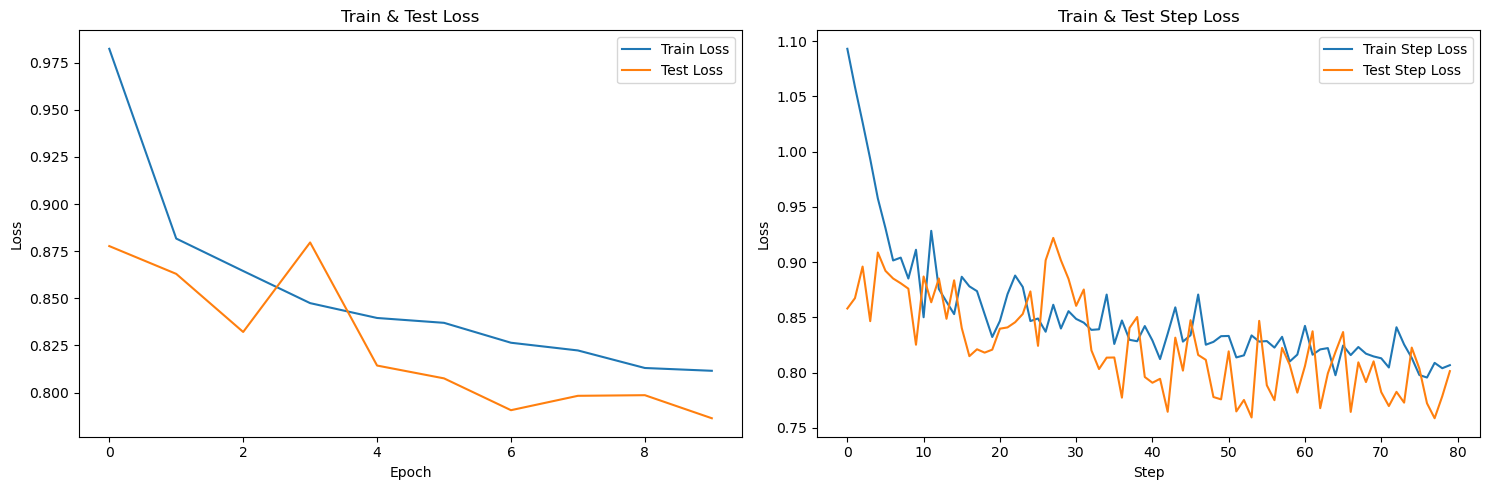

In [9]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_step_losses, label='Train Step Loss')
plt.plot(test_step_losses, label='Test Step Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Train & Test Step Loss')
plt.legend()

plt.tight_layout()
plt.show()